In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

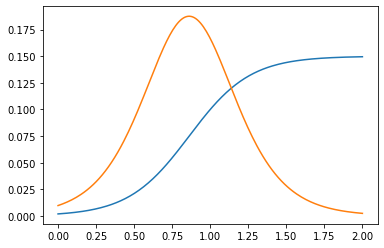

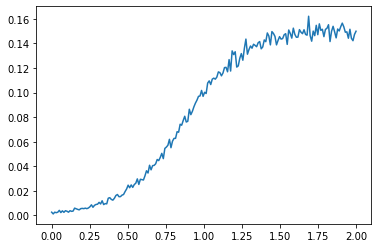

In [2]:
#parameters
tau_s = 3 # in ms
tau_L = 10
g_L = 0.1
g_D = 2
E_E = 4.667
E_I = -0.333
threshold = 1
phi_max = 0.15 #rate in 1/ms
k = 0.5
beta = 5
tau_ref = 3
tau_del = 100
eta = 0.07

T = 200  #run length in ms
dt = 0.1   #time interval in ms
N_t = int(T/dt)  #time steps

N_in = 200   #input dim
r_in = 10 # input spike rate in Hz 

def heavs(t):
    return t>=0

def rate_func(U):
    return phi_max/(1+k*np.exp(beta*(threshold-U)))

def h(V):
    return k*beta*np.exp(beta*(threshold-V))/(1+k*np.exp(beta*(threshold-V)))

def spike(U):
    return np.random.rand(len(U))<rate_func(U)*dt

def psp_kernel(t):
    return 1/(tau_L - tau_s)*heavs(t)*(np.exp(-t/tau_L) - np.exp(-t/tau_s))

def psp(spikes):
    ind_s = np.argwhere(spikes==1).flatten()
    if len(ind_s) == 0:
        return np.zeros_like(spikes)
    t = np.arange(len(spikes))*dt
    t = t[:,np.newaxis] - ind_s[np.newaxis,:]*dt
    return np.sum(psp_kernel(t), axis=1)

u = np.linspace(0,2, 200)
plt.plot(u, rate_func(u))
plt.plot(u, rate_func(u)*h(u))
plt.show()

plt.plot(u, np.sum([spike(u) for k in range(100000)], axis=0)/dt/100000)
plt.show()

probability of spike per interval: 0.001000
380


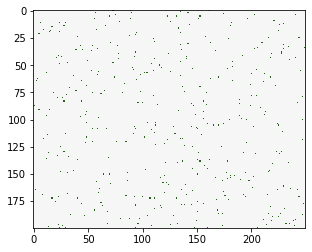

In [3]:
#input spike trains
#r_in*dt[s] << 1
print("probability of spike per interval: %f"%(r_in*dt*10**-3))
s = np.random.rand(N_in, N_t) < r_in*dt*10**-3
N_binned = 250
s_binned = np.sum(s.reshape((N_in, -1, N_binned)), axis=1)
plt.imshow(s_binned, cmap="PiYG", vmin=-1, vmax=1)
print(np.sum(s))

In [4]:
#Layer of N neurons (soma voltage U + dendritic potential V), N_in input currents
class Layer:
    
    def __init__(self, N_in, N):
        self.N_in = N_in
        self.N = N
        self.W = np.random.sample((N, N_in))*0.3+0.05#np.random.gamma(0.2, 0.2, (N, N_in))
        self.Delta = np.zeros((N, N_in))
        self.I = np.zeros(N)
        self.V = np.zeros(N)
        self.U = np.zeros(N)
        self.S = np.zeros(N)
        self.I_gw = np.zeros((N_in))
        self.V_gw = np.zeros((N_in))
        self.time = 0
        self.last = (-tau_ref -1)*np.ones_like(self.U)
        
    def update(self, S_in, g_E, g_I): #ignoreing refractory time
        self.time += dt
        
        ###evaluate updates
        #learning rule
        V_star = self.V*g_D/(g_L+g_D)
        dI_gw = dt/tau_s * (-self.I_gw + S_in/dt) 
        dV_gw = dt/tau_L * (-self.V_gw + self.I_gw)
        PI = np.outer((self.S/dt -rate_func(V_star))*h(V_star), self.V_gw)
        dDelta = dt/tau_del * (PI - self.Delta)
        dW = dt*eta*self.Delta
        
        dU = dt * (-g_L*self.U + g_D*(self.V-self.U) + g_E*(E_E-self.U) +g_I*(E_I-self.U))
        
        ###apply updates
        #spikeing?
        self.S = spike(self.U)
        ind = np.argwhere(self.S==1)
        if len(ind)>0:
            #self.U[ind] = 0
            self.last[ind] = self.time
        else:
            ind = self.time-self.last > -1#tau_ref
            self.U[ind] += dU[ind]
            
        self.I = np.matmul(self.W, self.I_gw)
        self.V = np.matmul(self.W, self.V_gw)
        self.I_gw  += dI_gw
        self.V_gw  += dV_gw
        self.Delta += dDelta
        self.W     += dW
             
    

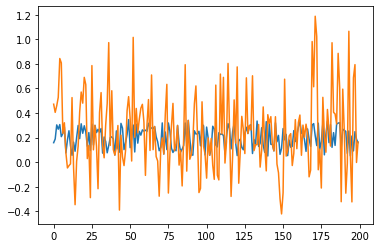

In [13]:
layer = Layer(N_in, 1)
n_runs = 100 #learning for 20s
V = np.zeros(n_runs*N_t)
U = np.zeros(n_runs*N_t)
S = np.zeros(n_runs*N_t)
W = np.zeros((n_runs*N_t, N_in))
W[0] = layer.W

g_E = np.zeros(n_runs*N_t)
g_I = np.zeros(n_runs*N_t)
#teaching signal for 0.2s- 19.8s
g_I[np.arange(N_t, (n_runs-1)*N_t)] = 2
g_E[np.arange(N_t, 2*N_t)] = 0.9*np.exp(-0.000005*(np.arange(N_t)-N_t/2)**2)
for i in range(2, n_runs-1):
    g_E[np.arange(i*N_t, (i+1)*N_t)] = g_E[np.arange(N_t, 2*N_t)]

#how do the weights evolve?
plt.plot(layer.W.flatten())
#run
for i in range(n_runs*N_t-1):
    layer.update(s[:, i%N_t], g_E[i], g_I[i])
    V[i+1] = layer.V[0]
    U[i+1] = layer.U[0]
    S[i+1] = layer.S[0]
    W[i+1] = layer.W[0]
    
plt.plot(layer.W.flatten())
plt.show()
    

<ipython-input-14-b0da016a6fe4>:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.arange(3*N_t)*dt, ((g_E*E_E+g_I*E_I)/(g_E+g_I))[:3*N_t])
<ipython-input-14-b0da016a6fe4>:11: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.arange((n_runs-3)*N_t, n_runs*N_t)*dt, ((g_E*E_E+g_I*E_I)/(g_E+g_I))[(n_runs-3)*N_t:])


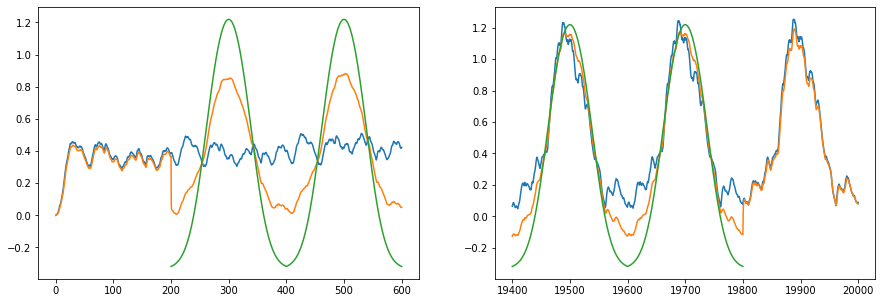

In [14]:
#plot beginning and end
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(np.arange(3*N_t)*dt, V[:3*N_t])
plt.plot(np.arange(3*N_t)*dt, U[:3*N_t])
plt.plot(np.arange(3*N_t)*dt, ((g_E*E_E+g_I*E_I)/(g_E+g_I))[:3*N_t])

plt.subplot(1,2,2)
plt.plot(np.arange((n_runs-3)*N_t, n_runs*N_t)*dt, V[(n_runs-3)*N_t:])
plt.plot(np.arange((n_runs-3)*N_t, n_runs*N_t)*dt, U[(n_runs-3)*N_t:])
plt.plot(np.arange((n_runs-3)*N_t, n_runs*N_t)*dt, ((g_E*E_E+g_I*E_I)/(g_E+g_I))[(n_runs-3)*N_t:])
plt.show()

## Synaptic diffusion and stability 

In [5]:
#run 60 times a 100s simulation without teaching to investigate weight diffusion
N_trials = 60
n_runs = 500 #learning for 100s
W = np.zeros((N_trials, 100, N_in), dtype=np.float32)

for n in range(N_trials):
    start = time.time()
    layer = Layer(N_in, 1)
    V = np.zeros(n_runs*N_t)
    U = np.zeros(n_runs*N_t)
    S = np.zeros(n_runs*N_t)
    w = np.zeros((n_runs*N_t, N_in))
    w[0] = layer.W

    g_E = np.zeros(n_runs*N_t)
    g_I = np.zeros(n_runs*N_t)
    #run
    for i in range(n_runs*N_t-1):
        layer.update(s[:, i%N_t], g_E[i], g_I[i])
        V[i+1] = layer.V[0]
        U[i+1] = layer.U[0]
        S[i+1] = layer.S[0]
        w[i+1] = layer.W[0]
        
    W[n] = np.mean(w.reshape((100, -1, N_in)), axis=1)
    print("%d/%d done. About %d min left"%(n+1, N_trials, int((N_trials-n-1)*(time.time()-start)/60)))

np.save("syn_diffusion_weights", W)

1/60 done. About 118 min left
2/60 done. About 119 min left
3/60 done. About 117 min left
4/60 done. About 110 min left
5/60 done. About 107 min left
6/60 done. About 106 min left
7/60 done. About 103 min left
8/60 done. About 101 min left
9/60 done. About 100 min left
10/60 done. About 97 min left
11/60 done. About 95 min left
12/60 done. About 93 min left
13/60 done. About 91 min left
14/60 done. About 89 min left
15/60 done. About 88 min left
16/60 done. About 85 min left
17/60 done. About 83 min left
18/60 done. About 83 min left
19/60 done. About 80 min left
20/60 done. About 77 min left
21/60 done. About 76 min left
22/60 done. About 74 min left
23/60 done. About 74 min left
24/60 done. About 71 min left
25/60 done. About 68 min left
26/60 done. About 66 min left
27/60 done. About 64 min left
28/60 done. About 62 min left
29/60 done. About 60 min left
30/60 done. About 58 min left
31/60 done. About 57 min left
32/60 done. About 55 min left
33/60 done. About 52 min left
34/60 done

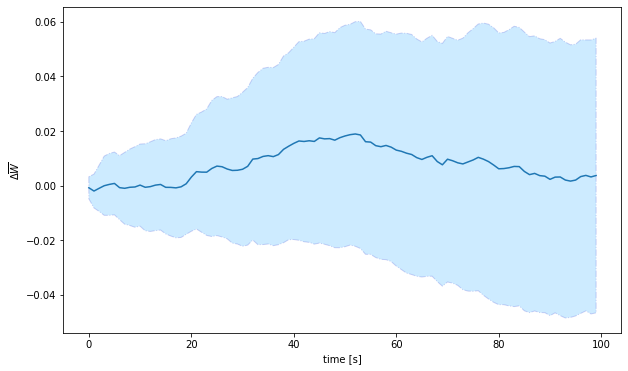

In [12]:
ts = np.arange(100)
avg_W = np.mean(W-0.2, axis=2) #average over neurons
mean = np.mean(avg_W, axis=0) #mean average neuron weight difference
plt.figure(figsize=(10,6))
plt.plot(ts, mean)
plt.fill_between(ts, mean - 0.5*np.std(avg_W, axis=0), mean + 0.5*np.std(avg_W, axis=0),
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                    linestyle='dashdot')
plt.xlabel("time [s]")
plt.ylabel("$\\Delta \\overline{W}}$")
plt.savefig("syn_diff.png")
plt.show()